## GHZ State Characterization

## Introduction to the GHZ state 

The Greenberger-Horne-Zeilinger (GHZ)  State is a $n$-qubit entangled state best defined by the following state vector:

$$ |\psi \rangle = \frac{|0 \rangle ^{\otimes n} + |1 \rangle ^{\otimes n}}{\sqrt{2}} , n > 2$$

Characterization of the GHZ state is very useful in assessing multi-qubit interactions, whose robustness is key to developing large scale quantum computers in the future. 

## Characterizing a quantum state

Every state $ | \psi \rangle $ can be uniquely identified by a density matrix, defined as $ \rho = \Sigma_{i} |\psi_{i} \rangle \langle \psi_{i}| $, where ${|\psi_{i} \rangle }$ is a complete and orthogonal basis for the state vector. After we prepare a GHZ State, it will have a density matrix denoted $\rho_{p}$. We want to see how close this matrix is to the density matrix of an actual GHZ State, $\rho_{T}$. One method to judge this similarity is to calculate the fidelity of the system, $F(\rho_{p},\rho_{T})$

$$F = Tr \Big[ \sqrt{\sqrt{\rho_{p}}\rho_{T}\sqrt{\rho_{p}}} \Big] ^{2}$$

The aim of this tutorial is two-fold: we will explore ways in which we can characterize the GHZ state, and ways in which we can use Ignis's error mitigation tools to increase readout fidelity, regardless of characterization method

Before we go further, ket us import everything from basic Qiskit that we will need:

In [1]:
from qiskit import *
from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.circuit import Parameter
from qiskit.providers.aer import noise


import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

These next two function are from ignis. The first is for the general error mitigation technique, and the second is specifically for quantum tomography

In [2]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter

The following import from the `entanglement` package contains new information needed to create, parallellize and analyze GHZ State circuits

In [3]:
from entanglement.parallelize import BConfig
from entanglement.linear import *
from entanglement.analysis import Plotter

## Preparing a GHZ State

Let us first go over how to prepare a GHZ State:

Say we have a system of $n$ qubits, all prepared in the $|0\rangle$ state:

$$|\psi \rangle = |00...0\rangle$$

To the first qubit, we apply a Hadamard gate to the first qubit: $|0\rangle \longrightarrow \frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)$. Our state now looks like:

$$|\psi \rangle = \frac{|00...0\rangle + |10...0\rangle}{\sqrt{2}} $$

We now apply a recursive and sequencial CNOT gate between the $n^{th}$ and $(n+1)^{th}$ qubits, to create the GHZ State, whose state can be verified through:

$$|\psi \rangle = \frac{|00...0\rangle + |11...1\rangle}{\sqrt{2}} = |\psi \rangle = \frac{|0 \rangle ^{\otimes n} + |1 \rangle ^{\otimes n}}{\sqrt{2}} , n > 2$$

The following function creates this "linear" circuit that can measure the GHZ state:

In [4]:
qn = 5 #creating a 5 qubit GHZ state
circ_simple = get_ghz_simple(qn,obs=False) 

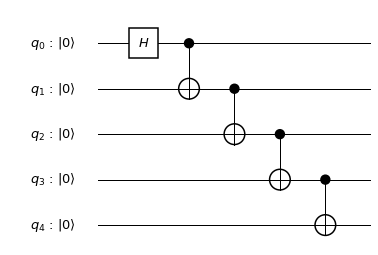

In [5]:
circ_simple.draw(output='mpl')

## Characterization, Part I

### Multiple Quantum Cohgerences (MQC)

MQC works by taking the preliminary preparation of an $n$ qubit GHZ State, and then by rotating each qubits state around the z axis by a phase $\phi$. After that, we apply a X gate, or a $\pi$ pulse around the x axis. This technique is similar to an echo seqeunce, and has be proven to substantially improve the fidelity during readout. Then, we apply the inverse of whatever operations we originally applied to get the GHZ state in the first place. In an ideal situation, we should be able to perfectly observe a phase collect on the final state: $|\psi \rangle = \frac{|0 \rangle ^{\otimes n} + e^{i n \phi}|1 \rangle ^{\otimes n}}{\sqrt{2}}$ by projecting it onto the state $|0 \rangle ^{\otimes n} $.)

The function below creates a linear MQC circuit. As with every circuit here on out, you can change the `extent` argument to either `'full'` (to measure all qubits) or `'one'` (to measure the control qubit). We will be using `extent = 'full'` as it will yield the most accurate results, but if you want to test MQC on >7 qubits, set `extent = 'one'`, and you will only have to observe oscillations between the `'0'` state and `'1'` state.

In [6]:
circ_mqc = get_ghz_mqc_para(qn,extent='one')

In [ ]:
# circ_mqc[0].draw(output='mpl') #uncomment to see the circuit

After running experiments on this MQC circuit, we can pick a state to observe oscillations in as we sweep $\phi$ from $0$ to $2 \pi$. Our signal in theory should follow $S(\phi) = \frac{1}{2}(1+cos(n \phi))$. We then perform a Discrete Fourier Transform ($I_{v}=(1/N)|\Sigma_{\phi}e^{iv\phi}S(\phi)$) to extract the Fidelity of the state, defined by the bounds $2\sqrt{I_{n}} \leq F \leq \sqrt{I_{0}/2}+ \sqrt{I_{n}}$; if desired, an actual value for the fidelity can be obtained: $F = \frac{1}{2}(P_{00...0}+P_{11...1})+\sqrt{I_{n}})$ (arXiv:1905.05720). 

### Parity Oscillations

The next method we use to characterize the GHZ state is parity oscillations. After preparing a GHZ state, we apply a combination of rotations about the x and y axes to create various superposition states as a function of $\phi$: $U(\phi) = \otimes_{j}^{N} e^{i\frac{\pi}{4}(cos(\phi)\sigma_{x}^{j}+sin(\phi)\sigma_{y}^{j})}$. We then measure the expectation value $\langle \otimes_{j}^{N} \sigma_{z}^{j} \rangle_{\phi}$ as a function of $\phi$, which in theory should lead to parity oscillations between 1 and -1.

The following function generates a circuit which is the Parity Oscillation equivalent of the MQC circuit given above

In [8]:
circ_po = get_ghz_po_para(qn)

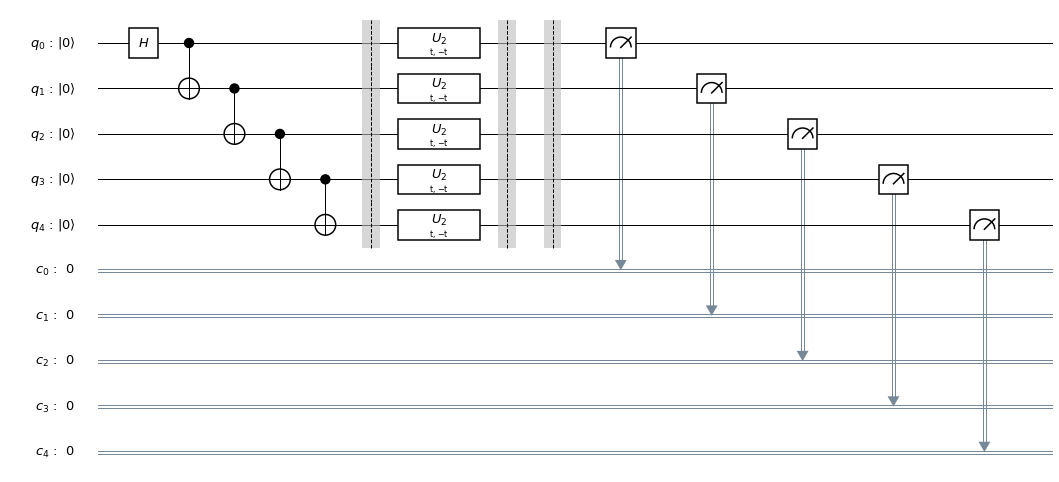

In [9]:
circ_po[0].draw(output='mpl')

We can obtain fidelity for parity oscillations $S_{\phi}$ from $F = \frac{1}{2}(P_{00...0}+P_{11...1}+C)$, where $C$, the coherence is defined as $2\sqrt{I_{n}}$, following the same convention for the DFT as with the MQC method.

### Tomography

Tomography entails physically measuring the density matrix, which should technicallybe concentrated around the 4 corners of the tensor-product basis. Although the fidelity will be readily provided, this method is extremely slow, and will literally take forever if a measurement of a >7 qubit state is required. Nevertheless, we will show how to perform this method for a small amount of qubits.

# Error Mitigation

Qiskit Ignis provides very accurate tools to take raw data and return calibrated data. This is done by getting the raw data, in the form of a vector $v_{raw}$ and getting a calibration matrix $A$. The output is then the solution to the optimization problem: $argmin_{v_{cal}} ||Av_{cal}-v_{raw}||^{2}$

# Parallelizing circuits

The above "linear" circuits are good to perform simulations, but what do we do when we use real devices, where the system can have an arbitrary topology and various errors? We cannot use Aer, as this experiment is pointless with a simulation. One technique is to parallelize the CNOT gates. This can be hugely beneficial efficiency wise, and fidelity wise. The class `BConfig` from the module `parallelize` does exactly this.

First we must configure the optimal backend we want to use. I am going a simulation backend disguised as a real device in the following way. First we load our accounts:

In [10]:


provider = IBMQ.load_account()


In [11]:
print(provider.backends())


[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmqx4') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>]


I am going to pick the simulation backend `'ibmq_qasm_simulator'` and the real device `'ibmq_16_melbourne'`

In [12]:

backend = provider.get_backend(name='ibmq_qasm_simulator')

backend_noisy = provider.get_backend(name='ibmqx2')


Using the `noise` module, we can now define a noise model from `'ibmq_16_melbourne'` to "assign" to `'ibmq_qasm_simulator'`.

In [13]:
noise_model = noise.device.basic_device_noise_model(backend_noisy.properties())
coupling_map = backend_noisy._configuration.coupling_map
basis_gates=noise_model.basis_gates

And there we have it. From now on, in the tutorial, when using a real device, not a simulation, just take out every mention and assignment of `noise_model` and `coupling_map`, and assign the real device to `backend`. The simulator used from now on is no substitute for running a real device.

`BConfig` lays the blueprint for creating paralellized circuits. Let us initialize an object taking in the real device we just defined, and name it `protocirc`. All of our experiments will use it:

In [14]:
protocirc = BConfig(backend_noisy)


# Experiment Time

## Preliminary Steps

The probabilities of measuring $|0\rangle ^{\otimes n}$ and $|1\rangle^{\otimes n}$ in the GHZ state are importance in measuring fidelity. For this, we need to run the following test


We first begin by defining standard execution parameters:

In [15]:
shots = 1024 #numbers of shots in a given experiment
max_credits = 3 #number of credits
qn = 5 #number of qubits
zerocode = '0'*qn #will help us easily define the state |00...00> 
onecode = '1'*qn #will help us easily define the state |11...11> 
sweep = np.arange(0.,np.pi*2,np.pi/16) #standard list of phase values we will sweep 

In [16]:
circ_simple, qr, initial_layout = protocirc.get_ghz_simple(qn)

In [17]:
# circ_simple.draw() #uncomment to see the circuit

In [18]:
job_simple = execute(circ_simple, backend, shots=shots, max_credits=max_credits,noise_model=noise_model)
# job_simple = execute(circ_simple, backend, shots=shots, max_credits=max_credits,noise_model=noise_model, coupling_map=coupling_map, basis_gates=basis_gates)

job_monitor(job_simple)
result_simple = job_simple.result()

Job Status: job has successfully run


In [19]:
P0 = (1/shots)*result_simple.get_counts()[zerocode]
P1 = (1/shots)*result_simple.get_counts()[onecode]
print('P(|00...0>) = ',P0)
print('P(|11...1>) = ',P1)

P(|00...0>) =  0.3017578125
P(|11...1>) =  0.3037109375


Now with error mitigation:

In [20]:
qr = QuantumRegister(qn)
qubit_list = range(qn)
meas_calibs_simple, state_labels_simple = complete_meas_cal(qubit_list=qubit_list, qr=qr, circlabel='mcal')

In [21]:
job_simple_em = qiskit.execute(meas_calibs_simple, backend=backend,
                     noise_model=noise_model)
job_monitor(job_simple_em)
meas_result = job_simple_em.result()

Job Status: job has successfully run


If an error shows up for the cell above ^, try running it again

In [22]:
meas_fitter = CompleteMeasFitter(meas_result,state_labels_simple,circlabel='mcal')
result_simple_em = meas_fitter.filter.apply(result_simple)

In [23]:
result_simple_em.get_counts()[zerocode]*1/shots

0.34186502254650225

In [24]:
P0_m = (1/shots)*result_simple_em.get_counts()[zerocode]
P1_m = (1/shots)*result_simple_em.get_counts()[onecode]
print('P(|00...0>) error mitigated = ',P0_m)
print('P(|11...1>) error mitigated = ',P1_m)

P(|00...0>) error mitigated =  0.34186502254650225
P(|11...1>) error mitigated =  0.35379500690957666


We will load these values in a dictionary for assessing fidelity later on:


In [25]:
p_dict = {'P0': P0, 'P1': P1, 'P0_m': P0_m, 'P1_m':P1_m}

## Part 1 : MQC

We now retrieve a parallellized MQC circuit for the n qubit device


In [26]:
shots = 1024 #numbers of shots in a given experiment
max_credits = 3 #number of credits
qn = 5 #number of qubits
zerocode = '0'*qn #will help us easily define the state |00...00> 
sweep = np.arange(0.,np.pi*2,np.pi/16) #standard list of phase values we will sweep 

In [27]:
%%time
circ, theta,initial_layout = protocirc.get_ghz_mqc_para(qn)
circ_total_mqc = [circ.bind_parameters({theta:t}) for t in sweep]

CPU times: user 182 ms, sys: 4.19 ms, total: 186 ms
Wall time: 184 ms


We now execute the MQC experiment:

In [28]:
job_exp_mqc = execute(circ_total_mqc, backend, shots=shots, max_credits=max_credits,
                      noise_model=noise_model,coupling_map=coupling_map,basis_gates=basis_gates)
job_monitor(job_exp_mqc)
result_exp_mqc = job_exp_mqc.result()

Job Status: job has successfully run


Now we will plot the amount of counts measured for $|0 \rangle ^{\otimes n}$ as a function of phase. It is important to note that when using a parametrized circuit like the one here, the method `get_counts()` accepts an **index** and not a **circuit**. In any other type of experiment, `get_counts()` accepts a **circuit**.

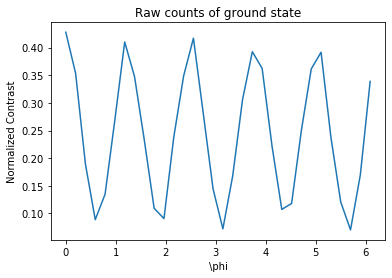

In [29]:
zeros = [(1/shots)*result_exp_mqc.get_counts(a)[zerocode] if 
          zerocode in result_exp_mqc.get_counts(a) else 0 for a in range(len(sweep)) ] #notice the important difference with proto2; takes only the index, not the actual circuit
Plotter('mqc').sin_plotter(sweep,zeros)

Now we get started on error mitigation. We create an identical quantum register and use complete_meas_cal from Ignis, to create circuits for calibrated measurements to be excecuted, and a calibration matrix.

In [30]:
qr = qiskit.QuantumRegister(qn)
qubit_list = range(qn)
meas_calibs_mqc, state_labels_mqc = complete_meas_cal(qubit_list=qubit_list, qr=qr, circlabel='mcal') #from Ignis

In [32]:
job_cal_mqc = qiskit.execute(meas_calibs_mqc, backend=backend,
                     noise_model=noise_model,coupling_map=coupling_map,basis_gates=basis_gates)
job_monitor(job_cal_mqc)
meas_result_mqc = job_cal_mqc.result()

Job Status: job has successfully run


In [33]:
meas_fitter_mqc = CompleteMeasFitter(meas_result_mqc,state_labels_mqc,circlabel='mcal')
# print(meas_fitter.cal_matrix) #uncomment this to see how close the calibration matrix is to the calibration matrix

Finally, we have our error mitigated results:

In [34]:
result_exp_em = meas_fitter_mqc.filter.apply(result_exp_mqc)

We can see how the error mitigated results yield a far greater fidelity than the raw data

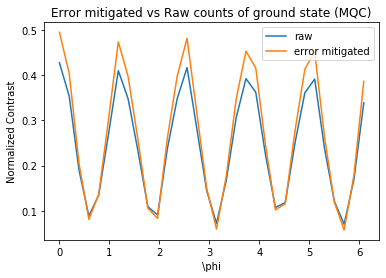

In [35]:
zeros_m = [(1/shots)*result_exp_em.get_counts(a)[zerocode] if 
          zerocode in result_exp_em.get_counts(a) else 0 for a in range(len(sweep)) ]

Plotter('mqc').sin_plotter(sweep,zeros,zeros_m)

Upper/Lower raw fidelity bounds =  0.633  +/-  0.006  ||  0.568  +/- 0.006
Upper/Lower error mitigated fidelity bounds =  0.681  +/-  0.007  ||  0.629  +/-  0.006
Raw fidelity =  0.632  +/-  0.006
Mitigated fidelity =  0.662  +/-  0.007


{'I0': (0.24298095703125+0j),
 'In': (0.08063455879458856+0.002537226125735647j),
 'I0_m': (0.2691078795159022+0j),
 'In_m': (0.09877712377323065+0.002958956599915254j),
 'LB': 0.5680650201118931,
 'UB': 0.6325873529653874,
 'LB_m': 0.6287175293360082,
 'UB_m': 0.6811747127372656,
 'F': 0.631862524783986,
 'F_m': 0.6621887793960435}

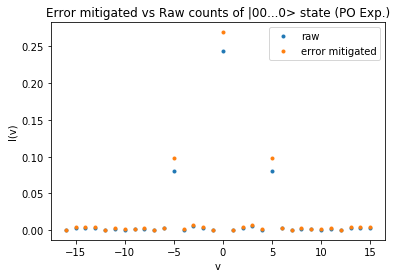

In [36]:
Plotter('mqc').get_fourier_info(qn,sweep,zeros,zeros_m,p_dict)

We now plot the DFT and compare the heights of the peaks to give bounds for the fidelity

Statistical bootstrapping has found that the error on these measurements is at most 1.5% (arXiv 1905.05720), so these result fall within error bounds, despite the fidelity being slightly higher than the upper bound, and show how error mitigation dramatically increases fidelity

## Part 2: Parity Oscillation

We now retrieve a parallellized Parity Oscillation circuit for the n qubit device, and run experiments in the same fashion as we did in MQC.


In [37]:
shots = 1024
max_credits = 3
qn = 5
zerocode = '0'*qn
sweep = np.arange(0,np.pi*2,np.pi/16)

In [38]:
%%time
circ, [theta,thetaneg] , initial_layout = protocirc.get_ghz_po_para(qn)

circ_total = [circ.bind_parameters({theta:t, thetaneg:-t}) for t in sweep]

CPU times: user 210 ms, sys: 7.79 ms, total: 218 ms
Wall time: 216 ms


In [39]:
job_exp = execute(circ_total, backend, shots=shots, max_credits=max_credits,
                  noise_model=noise_model, coupling_map=coupling_map, basis_gates=basis_gates)
job_monitor(job_exp)
result_exp = job_exp.result()

Job Status: job has successfully run


Now we construct the $\otimes _{j}^{N} \sigma_z^{j}$ matrix for instruction, although this is already taken into account in the following method, `entanglement.analysis.composite_paul_z_expvalue()`:

In [40]:
composite_sigma_z = sigma_z = np.array([[1, 0],[0, -1]])
for a in range(1,qn):
    composite_sigma_z = np.kron(composite_sigma_z,sigma_z)

Now we want to make sure that our list of counts is correctly ordered so that it coincides with the states of the $\otimes _{j}^{N} \sigma_z^{j}$, so that calculating  $\langle \otimes _{j}^{N} \sigma_z^{j} \rangle$ will be as simple as taking the dot product of this ordered list with the diagonal of $\otimes _{j}^{N} \sigma_z^{j}$. The `composite_pauli_z_expvalue` function does just that; it takes a circuit and appropriately orders the state vector counts. We can plot this dot product as a function of $\phi$ to observe parity oscillations.

In [41]:
from entanglement.analysis import composite_pauli_z_expvalue

In [42]:
y = [ (1/shots)*composite_pauli_z_expvalue(result_exp.get_counts(i),qn) for i in range(len(sweep))]

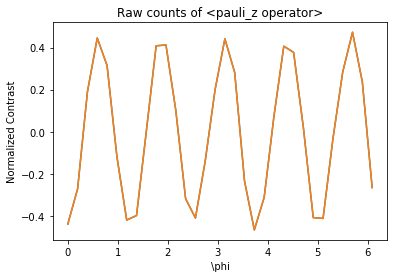

In [43]:
plt.plot(sweep,y)
Plotter('po').sin_plotter(sweep,y)

Now for standard error mitigation:

In [44]:
qr = qiskit.QuantumRegister(qn)
qubit_list = range(qn)
meas_calibs, state_labels = complete_meas_cal(qubit_list=qubit_list, qr=qr, circlabel='mcal')

In [45]:
job_cal = qiskit.execute(meas_calibs, backend=backend,
                  noise_model=noise_model, coupling_map=coupling_map, basis_gates=basis_gates)
job_monitor(job_cal)
meas_result = job_cal.result()

Job Status: job has successfully run


In [46]:
meas_fitter = CompleteMeasFitter(meas_result,state_labels,circlabel='mcal')
result_exp_em = meas_fitter.filter.apply(result_exp)


In [47]:
y_m = [ (1/shots)*composite_pauli_z_expvalue(result_exp_em.get_counts(i),qn) for i in range(len(sweep))]

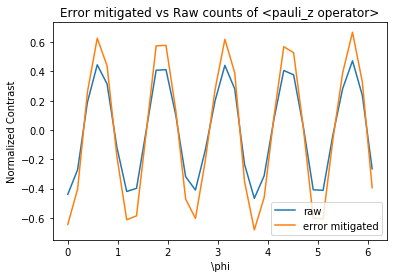

In [48]:
Plotter('po').sin_plotter(sweep,y,y_m)

We can see how error mitigation dramatically improves our measurement (much more so in PO than in MQC). Let us quantify this using the same DFT method we used in MQC, and calulating the actual fidelities:

Raw fidelity =  0.531  +/-  0.005
Mitigated fidelity =  0.675  +/-  0.007


{'In': (-0.22791641640593036-0.0006668987189362551j),
 'In_m': (-0.32748569447625203-0.0009257231442616064j),
 'F': 0.5306517670990295,
 'F_m': 0.6753170175998067}

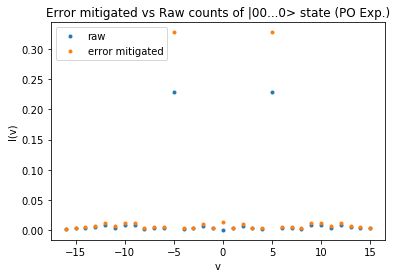

In [49]:
Plotter('po').get_fourier_info(qn,sweep,y,y_m,p_dict)

As we see, the raw fidelity is much lower than what is acheived with MQC, but the error mitigated result is about the same.

## Part 3: Tomography

The first step in this experiment to just pass a simple GHZ state with *no* measurements. Also, the circuit cannot be transpiled; the `transpiled` argument in the `getGHZChecker()` method can be turned on and off as is shown

In [50]:
shots = 1024
max_credits = 3
qn = 5
zerocode = '0'*qn
q = QuantumRegister(qn, 'q')

In [51]:
circ_total, initial_layout = protocirc.get_ghz_layout(qn,transpiled=False)

We now pass a simulated backend from `Aer` to get theoretical statevector counts 

In [52]:
job_exp = execute(circ_total, Aer.get_backend('statevector_simulator'), shots=shots, max_credits=max_credits)
job_monitor(job_exp)
result_exp = job_exp.result()
psi_exp = result_exp.get_statevector(circ_total)

Job Status: job has successfully run


This following code runs tomography experiments on the circuit we defined first, which is then compared to the theortical statevector to generate a density matrix

In [53]:
qst = state_tomography_circuits(circ_total,q)
job = qiskit.execute(qst, backend, shots=shots, initial_layout=initial_layout,noise_model=noise_model, coupling_map=coupling_map, basis_gates=basis_gates)
job_monitor(job)

Job Status: job has successfully run


In [54]:
tomo = StateTomographyFitter(job.result(), qst)

From here we can get the fidelity, although this method is not as fool proof as the oone we will get to eventually:

In [55]:
F = quantum_info.state_fidelity(psi_exp,tomo.fit())

...And now for error mitigation...

In [56]:
qr = qiskit.QuantumRegister(qn)
qubit_list = range(qn)
meas_calibs, state_labels = complete_meas_cal(qubit_list=qubit_list, qr=qr, circlabel='mcal')

In [57]:
job_c = qiskit.execute(meas_calibs, backend=backend,
                  noise_model=noise_model, coupling_map=coupling_map, basis_gates=basis_gates)
job_monitor(job_c)
meas_result = job_c.result()


Job Status: job has successfully run


In [58]:
meas_fitter = CompleteMeasFitter(meas_result,state_labels,circlabel='mcal')
result_em = meas_fitter.filter.apply(job.result())

In [59]:
result_em = meas_fitter.filter.apply(job.result())
tomo_em = StateTomographyFitter(result_em, qst)

Now, using `qiskit.visualization`, we can plot the raw density matrix, real, and imiginary parts being on separate plots,...

/miniconda3/envs/qiskit/lib/python3.7/site-packages/qiskit/visualization/state_visualization.py:617: DeprecationWarning: plot_state is deprecated, and will be removed in                   the 0.9 release. Use the plot_state_ * functions                   instead.
  DeprecationWarning)
/miniconda3/envs/qiskit/lib/python3.7/site-packages/qiskit/visualization/state_visualization.py:770: MatplotlibDeprecationWarning: 
The mod function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.linalg.norm instead.
  for n in normals])


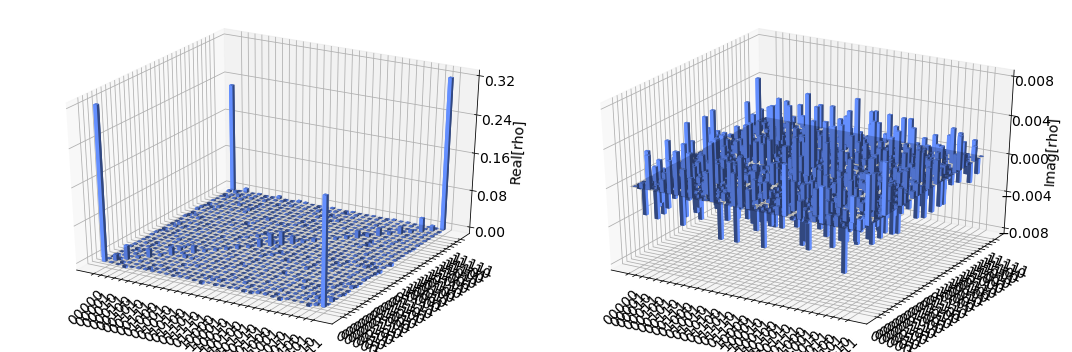

In [60]:
qiskit.visualization.plot_state(tomo.fit(),"city")

And also the error mitigated density matrix,...

/miniconda3/envs/qiskit/lib/python3.7/site-packages/qiskit/visualization/state_visualization.py:617: DeprecationWarning: plot_state is deprecated, and will be removed in                   the 0.9 release. Use the plot_state_ * functions                   instead.
  DeprecationWarning)


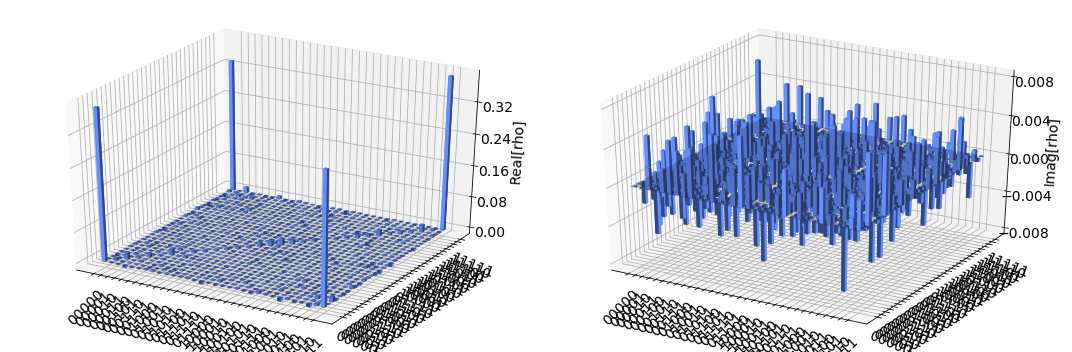

In [61]:
qiskit.visualization.plot_state(tomo_em.fit(),"city")

The actual density matrices can be obtained using the `fit()` method. Once we have the density matrix, we can compute the fidelity, which is nothing but half the sum of the four corners of the density matrix; the following method helps us: 

In [62]:
from entanglement.analysis import rho_to_fidelity

In [63]:
rho, rho_em = tomo.fit() , tomo_em.fit()

In [64]:
F = rho_to_fidelity(rho)
F_em = rho_to_fidelity(rho_em)

In [65]:
print("Raw fidelity: ",F)
print("Error mitigated fidelity: ",F_em)

Raw fidelity:  0.5520997748368797
Error mitigated fidelity:  0.7220855193368751


As we see, the raw fidelity is much lower than what is acheived with either MQC or Parity Oscillations, but the error mitigated result is about the same.

**A note on tomography**

Do not perform quantum tomography with >5 qubits

# Conclusion

In conclusion, we see that without error mitigation, MQC is the superior method for characterizing the GHZ state. However, with error mitigation, all methods can, at least for a small number of qubits, acheive a much greater fidelity, and all near the same value. To get more accurate results, aside from using a real device, it is worth increase the number of shots four to eight-fold. It may be worth comparing how the parallellized circutis used in this notebook perform fidelity-wise versus linearized circuits.